*Copyright (c) Microsoft Corporation. All rights reserved.*                 
*Licensed under the MIT License.*

In [1]:
%matplotlib inline

# Interpreting Bag of Words Text Classification models

_**This notebook showcases how to use the interpret-text repo to implement an interpretable module using feature iportances and bag of words representation.**_


## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Training](#Training)
4. [Results](#Results)




In [2]:
import os
from interpret_text.linear.linear_text_explainer import LinearTextExplainer

# sklearn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# nlp recipes
from utils_nlp.dataset.multinli import load_pandas_df

# for testing
from scrapbook.api import glue

working_dir = os.getcwd()


## 1. Introduction
This notebook illustrates how to locally use interpret-text to help interpret text classification using a logisitic regression baseline and bag of words encoding. It demonstrates the API calls needed to obtain the feature importances along with a visualization dashbard.

###### Note:
* *Although we use logistic regression, any model that follows sklearn's classifier API should be supported natively or with minimal tweaking.*
* *The interpreter supports interpretations using either coefficients associated with linear models or feature importances associated with ensemble models.*
* *The classifier relies on scipy's sparse representations to keep the dataset in memory.*

## 2. Setup

The notebook is built on features made available by [Sci-kit Learn](https://scikit-learn.org/stable/) and [spacy](https://spacy.io/) for easier compatibiltiy with popular tookits.                     
The notebook also relies on the pip installable "utils_nlp.dataset.multinli" package from Microsoft's [NLP-recipes](https://github.com/microsoft/nlp-recipes/tree/master/utils_nlp) open source package for dataloading purposes. 

### Configuration Parameters

In [3]:
DATA_FOLDER = './temp'
TRAIN_SIZE = 0.7
TEST_SIZE = 0.3

### Data

In [4]:
df = load_pandas_df(DATA_FOLDER, "train")
df = df[df["gold_label"] == "neutral"]  # get unique sentences

# fetch documents and labels from data frame
X_str = df['sentence1']  # the document we want to analyze
ylabels = df['genre'] # the labels, or answers, we want to test against

### Preprocessing Setup

In the default LinearExplainer, each text document in the dataset undergoes the following preprocessing steps during conversion into tokens:
* Use spacy's English parser to parse document.
* Convert to lower case.
* Strip off white space surrounding each word.
* [lemmatize](https://en.wikipedia.org/wiki/Lemmatisation) based on spacy's language model.
* Remove stop words and punctuation to obtain tokens.

In [5]:
# Create explainer object that contains defaault glassbox classfier and explanation methods
explainer = LinearTextExplainer()
label_encoder = LabelEncoder()

## Training

###### Note: Vocabulary

* *The vocabulary is compiled from the dataset. Any word that does not appear in the data set, will not appear in the vocabulary. Additionally, each dataset will have a different vocabulary set.*
* *The word must appear one or more times to be considered part of the vocabulary.*
* *However, the sklearn countvectorizer allows the addition of a custom vocabulary as an input parameter.*

### Configure training setup
This step will cast the training data and labels into the correct format

1. Split data into train and test using a random shuffle
2. Load desired classifier. In this case, Logistic Regression.
3. Setup grid search for hyperparameter optimization and train model. Edit the hyper parameter range to search over as per your model.
4. Fit models to train set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_str, ylabels, train_size=0.8, test_size=0.2)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [7]:
print("X_train shape =" + str(X_train.shape))
print("y_train shape =" + str(y_train.shape))
print("X_train data structure = " + str(type(X_train)))

X_train shape =(104720,)
y_train shape =(104720,)
X_train data structure = <class 'pandas.core.series.Series'>


#### Model Overview

The [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) allows a 1:1 mapping from individual words to their respective frequencies in the [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix).                                
We use spacy's medium language [model](https://spacy.io/models/en#en_core_web_md) which is trained on common crawl for text preprocessing.

In [8]:
classifier, best_params = explainer.fit(X_train, y_train)

C:\Users\abchhetr\AppData\Local\Continuum\anaconda3\envs\interpret-text\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Results

###### Note:
* *The parameters are set using cross-validation*
* *Below listed hyperparamters are selected by searching over a larger space.*
* *These apply speciically to this instance of the logistic regression model and mnli dataset.*
* *'Multinomial' setup was found to be better than 'one-vs-all' across the board*
* *Default 'liblinear' solver is not supported for 'multinomial' model setup*
* *For a different model or dataset, set the range as appropriate using the hyperparam_range argument in the train method* 

In [9]:
# obtain best classifier and hyper params
print("best classifier: " + str(best_params))

best classifier: {'C': 10000, 'multi_class': 'multinomial', 'solver': 'saga'}


## Performance Metrics

In [10]:
mean_accuracy = classifier.score(X_test, y_test, sample_weight=None)
print("accuracy = " + str(mean_accuracy * 100) + "%")
y_pred = classifier.predict(X_test)
[precision, recall, fscore, support] = precision_recall_fscore_support(y_test, y_pred,average='macro')

accuracy = 84.75935828877004%


Capture metrics for integration testing

In [11]:
glue("accuracy", mean_accuracy)
glue("precision", precision)
glue("recall", recall)
glue("f1", fscore)
print("[precision, recall, fscore, support] = " + str([precision, recall, fscore, support]))

[precision, recall, fscore, support] = [0.8511874219480928, 0.8476464522719971, 0.8484727118134978, None]


## Global importances

Global importances are the most and least important words for each class over the entire dataset. You can only get the global importance one label at a time.

The class names are as follows
['fiction' 'government' 'slate' 'telephone' 'travel']


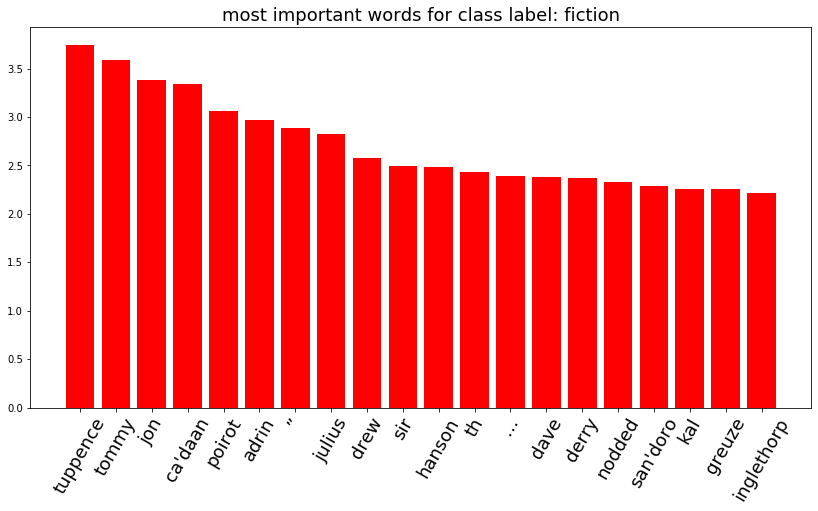

In [12]:
print("The class names are as follows")
print(label_encoder.classes_)
label_name = "fiction"

# Obtain the top feature ids for the selected class label.
# Map top features back to words.
explainer.preprocessor.labelEncoder = label_encoder
top_words, top_importances = explainer.explain_global(label_name)

## Local Importances

Local importances are the most and least important words for a single document.

In [13]:
# Obtain the top feature ids for the selected class label.
# Map top features back to words.
# top_words, top_importances = explainer.explain_global(label_name)

# Enter any document & label pair that needs to be interpreted
document = "I travelled to the beach. I took the train. I saw faries, dragons and elves"

# Obtain the top feature ids for the selected class label
word_importances, parsed_sentence = explainer.explain_local(document)

In [14]:
parsed_sentence

['I',
 'travelled',
 'to',
 'the',
 'beach',
 '.',
 'I',
 'took',
 'the',
 'train',
 '.',
 'I',
 'saw',
 'faries',
 ',',
 'dragons',
 'and',
 'elves']

In [15]:
# Visualize local feature importances as a heatmap over words in the document
explainer.visualize(word_importances, parsed_sentence)